## Understanding Eager Batching on Hailo devices with DeGirum PySDK

This guide demonstrates how **eager batching** affects inference performance on Hailo-8 and Hailo-8L devices using the DeGirum PySDK. It walks through live benchmarks comparing different models and batching strategies. **Eager batching** in DeGirum PySDK queues multiple inference requests and sends them to the accelerator as a batch. This can improve inference throughput—**but only for multi-context models**.


#### Understanding Context Size

In Hailo's architecture, **context size** refers to how many model instances (contexts) can be concurrently loaded into the accelerator:

- **Single-context models**: Fully fit into Hailo's memory. Adding batching doesn’t improve performance because the model already saturates the accelerator.
  
- **Multi-context models**: Too large to fit completely, so Hailo divides execution across contexts. Batching allows better hardware utilization and **can significantly improve FPS**.


## What This Guide Demonstrates

We run two models:
- A **YOLOv8n object detection model** (context = 1)
- A **YOLOv8m object detection model** (context > 1)

Each is evaluated under:
- `eager_batch_size = 1` (no batching)
- `eager_batch_size = 8` (batched)

We measure **frames per second (FPS)** using PySDK and visualize the results.


## Installation & imports

In [5]:
!pip install -U degirum 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 11.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: degirum
    Found existing installation: degirum 0.17.0
    Uninstalling degirum-0.17.0:
      Successfully uninstalled degirum-0.17.0

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import degirum as dg
import degirum_tools

## Load the model

In [14]:
iterations = 1000
model_zoo = 'degirum/hailo'
inference_host_address = '@local'
single_context_model = 'yolov8n_coco--640x640_quant_hailort_hailo8_1'
multi_context_model = 'yolov8m_coco--640x640_quant_hailort_hailo8_1'
token = ''

## Eager batching on single context model

#### batch size = 1

In [15]:
# Load the model
model = dg.load_model(
    model_name=single_context_model,
    inference_host_address=inference_host_address,
    zoo_url="https://hub.degirum.com/degirum/hailo",
    eager_batch_size=1,  # Set eager batch size to 1 for single context model
)

# Turn off C++-based post-processing (Does not affect models with a 'PythonFile' python-based postprocessor!)
model.output_postprocess_type = "None"

single_context_bs_1_results = degirum_tools.model_time_profile(model, iterations)
print(f"Running with batch size - {str(model._model_parameters.EagerBatchSize)}, Observed FPS: {single_context_bs_1_results.observed_fps:5.2f}")

Running with batch size - 1, Observed FPS: 318.95


#### batch size 8

In [16]:
# Load the model
model = dg.load_model(
    model_name=single_context_model,
    inference_host_address=inference_host_address,
    zoo_url="https://hub.degirum.com/degirum/hailo",
    eager_batch_size=8,  # Set eager batch size to 8 for single context model
)

# Turn off C++-based post-processing (Does not affect models with a 'PythonFile' python-based postprocessor!)
model.output_postprocess_type = "None"

single_context_bs_8_results = degirum_tools.model_time_profile(model, iterations)
print(f"Running with batch size - {str(model._model_parameters.EagerBatchSize)}, Observed FPS: {single_context_bs_8_results.observed_fps:5.2f}")

Running with batch size - 8, Observed FPS: 318.57


### Visualise the results for single context model

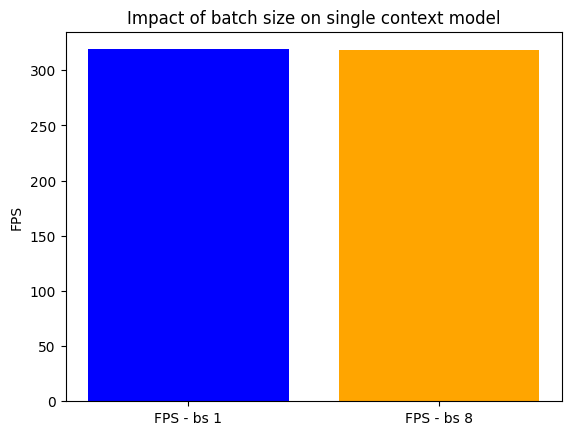

In [18]:
import matplotlib.pyplot as plt


# Labels and data
labels = ['FPS - bs 1', 'FPS - bs 8']
values = [single_context_bs_1_results.observed_fps, single_context_bs_8_results.observed_fps]

# Plotting
plt.bar(labels, values, color=['blue', 'orange'])

# Customizing
plt.ylabel('FPS')
plt.title('Impact of batch size on single context model')

# Show plot
plt.show()


## Eager batching on multi context model

#### batch size 1

In [19]:
# Load the model
model_a = dg.load_model(
    model_name=multi_context_model,
    inference_host_address=inference_host_address,
    zoo_url="https://hub.degirum.com/degirum/hailo",
    eager_batch_size=1 # Set eager batch size to 1 for multi context model
)

# Turn off C++-based post-processing (Does not affect models with a 'PythonFile' python-based postprocessor!)
model_a.output_postprocess_type = "None"

multi_context_bs_1_results = degirum_tools.model_time_profile(model_a, iterations)
print(f"Running with batch size - {str(model_a._model_parameters.EagerBatchSize)}, Observed FPS: {multi_context_bs_1_results.observed_fps:5.2f}")

Running with batch size - 1, Observed FPS: 50.70


#### batch size 8

In [20]:
# Load the model
model_b = dg.load_model(
    model_name=multi_context_model,
    inference_host_address=inference_host_address,
    zoo_url="https://hub.degirum.com/degirum/hailo",
    eager_batch_size=8  # Set eager batch size to 8 for multi context model 
)


# Turn off C++-based post-processing (Does not affect models with a 'PythonFile' python-based postprocessor!)
model_b.output_postprocess_type = "None"

multi_context_bs_8_results = degirum_tools.model_time_profile(model_b, iterations)
print(f"Running with batch size - {str(model_b._model_parameters.EagerBatchSize)}, Observed FPS: {multi_context_bs_8_results.observed_fps:5.2f}")

Running with batch size - 8, Observed FPS: 102.13


### Visualise the results for multi context models

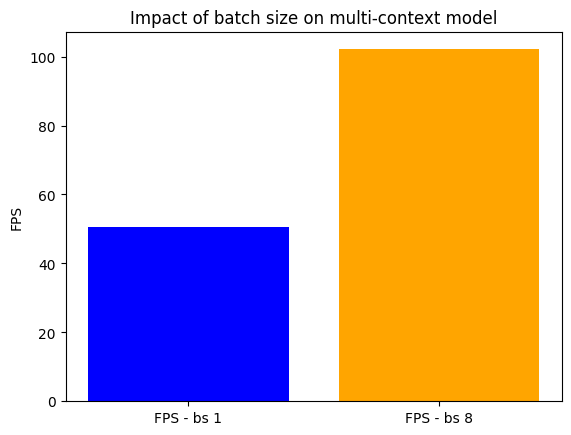

In [21]:
import matplotlib.pyplot as plt

# Labels and data
labels = ['FPS - bs 1', 'FPS - bs 8']
values = [multi_context_bs_1_results.observed_fps, multi_context_bs_8_results.observed_fps]

# Plotting
plt.bar(labels, values, color=['blue', 'orange'])

# Customizing
plt.ylabel('FPS')
plt.title('Impact of batch size on multi-context model')

# Show plot
plt.show()

## Conclusion

Eager batching can significantly improve inference performance on Hailo devices—but only for models that use multiple contexts due to their larger size. For smaller models that fully utilize the accelerator memory, batching adds no benefit and may introduce unnecessary latency. By understanding model context and evaluating FPS under different batch sizes, you can make informed decisions to optimize throughput based on your specific use case.
